In [1]:
from aicsimageio import AICSImage
import os

import numpy as np
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import napari_process_points_and_surfaces as nppas
import vedo

import napari
import napari_stress

In [2]:
# Config
surface_density = 0.01  # vertices/microns^2

In [3]:
filename = r'C:\Users\johamuel\Desktop\3-001.czi'
image = AICSImage(filename)

In [4]:
# This is the size of the whole data
image.dask_data

dask.array<transpose, shape=(24, 2, 326, 1600, 1600), dtype=uint16, chunksize=(1, 1, 326, 1600, 1600), chunktype=numpy.ndarray>

Since we can not move all data to the memory, we shall process one frame at a time. In this notebook, we'll focus on demonstrating the workflow *for a single timepoint*. Still large enough:

In [5]:
image.dask_data[0]

dask.array<getitem, shape=(2, 326, 1600, 1600), dtype=uint16, chunksize=(1, 326, 1600, 1600), chunktype=numpy.ndarray>

Assistant skips harvesting pyclesperanto as it's not installed.


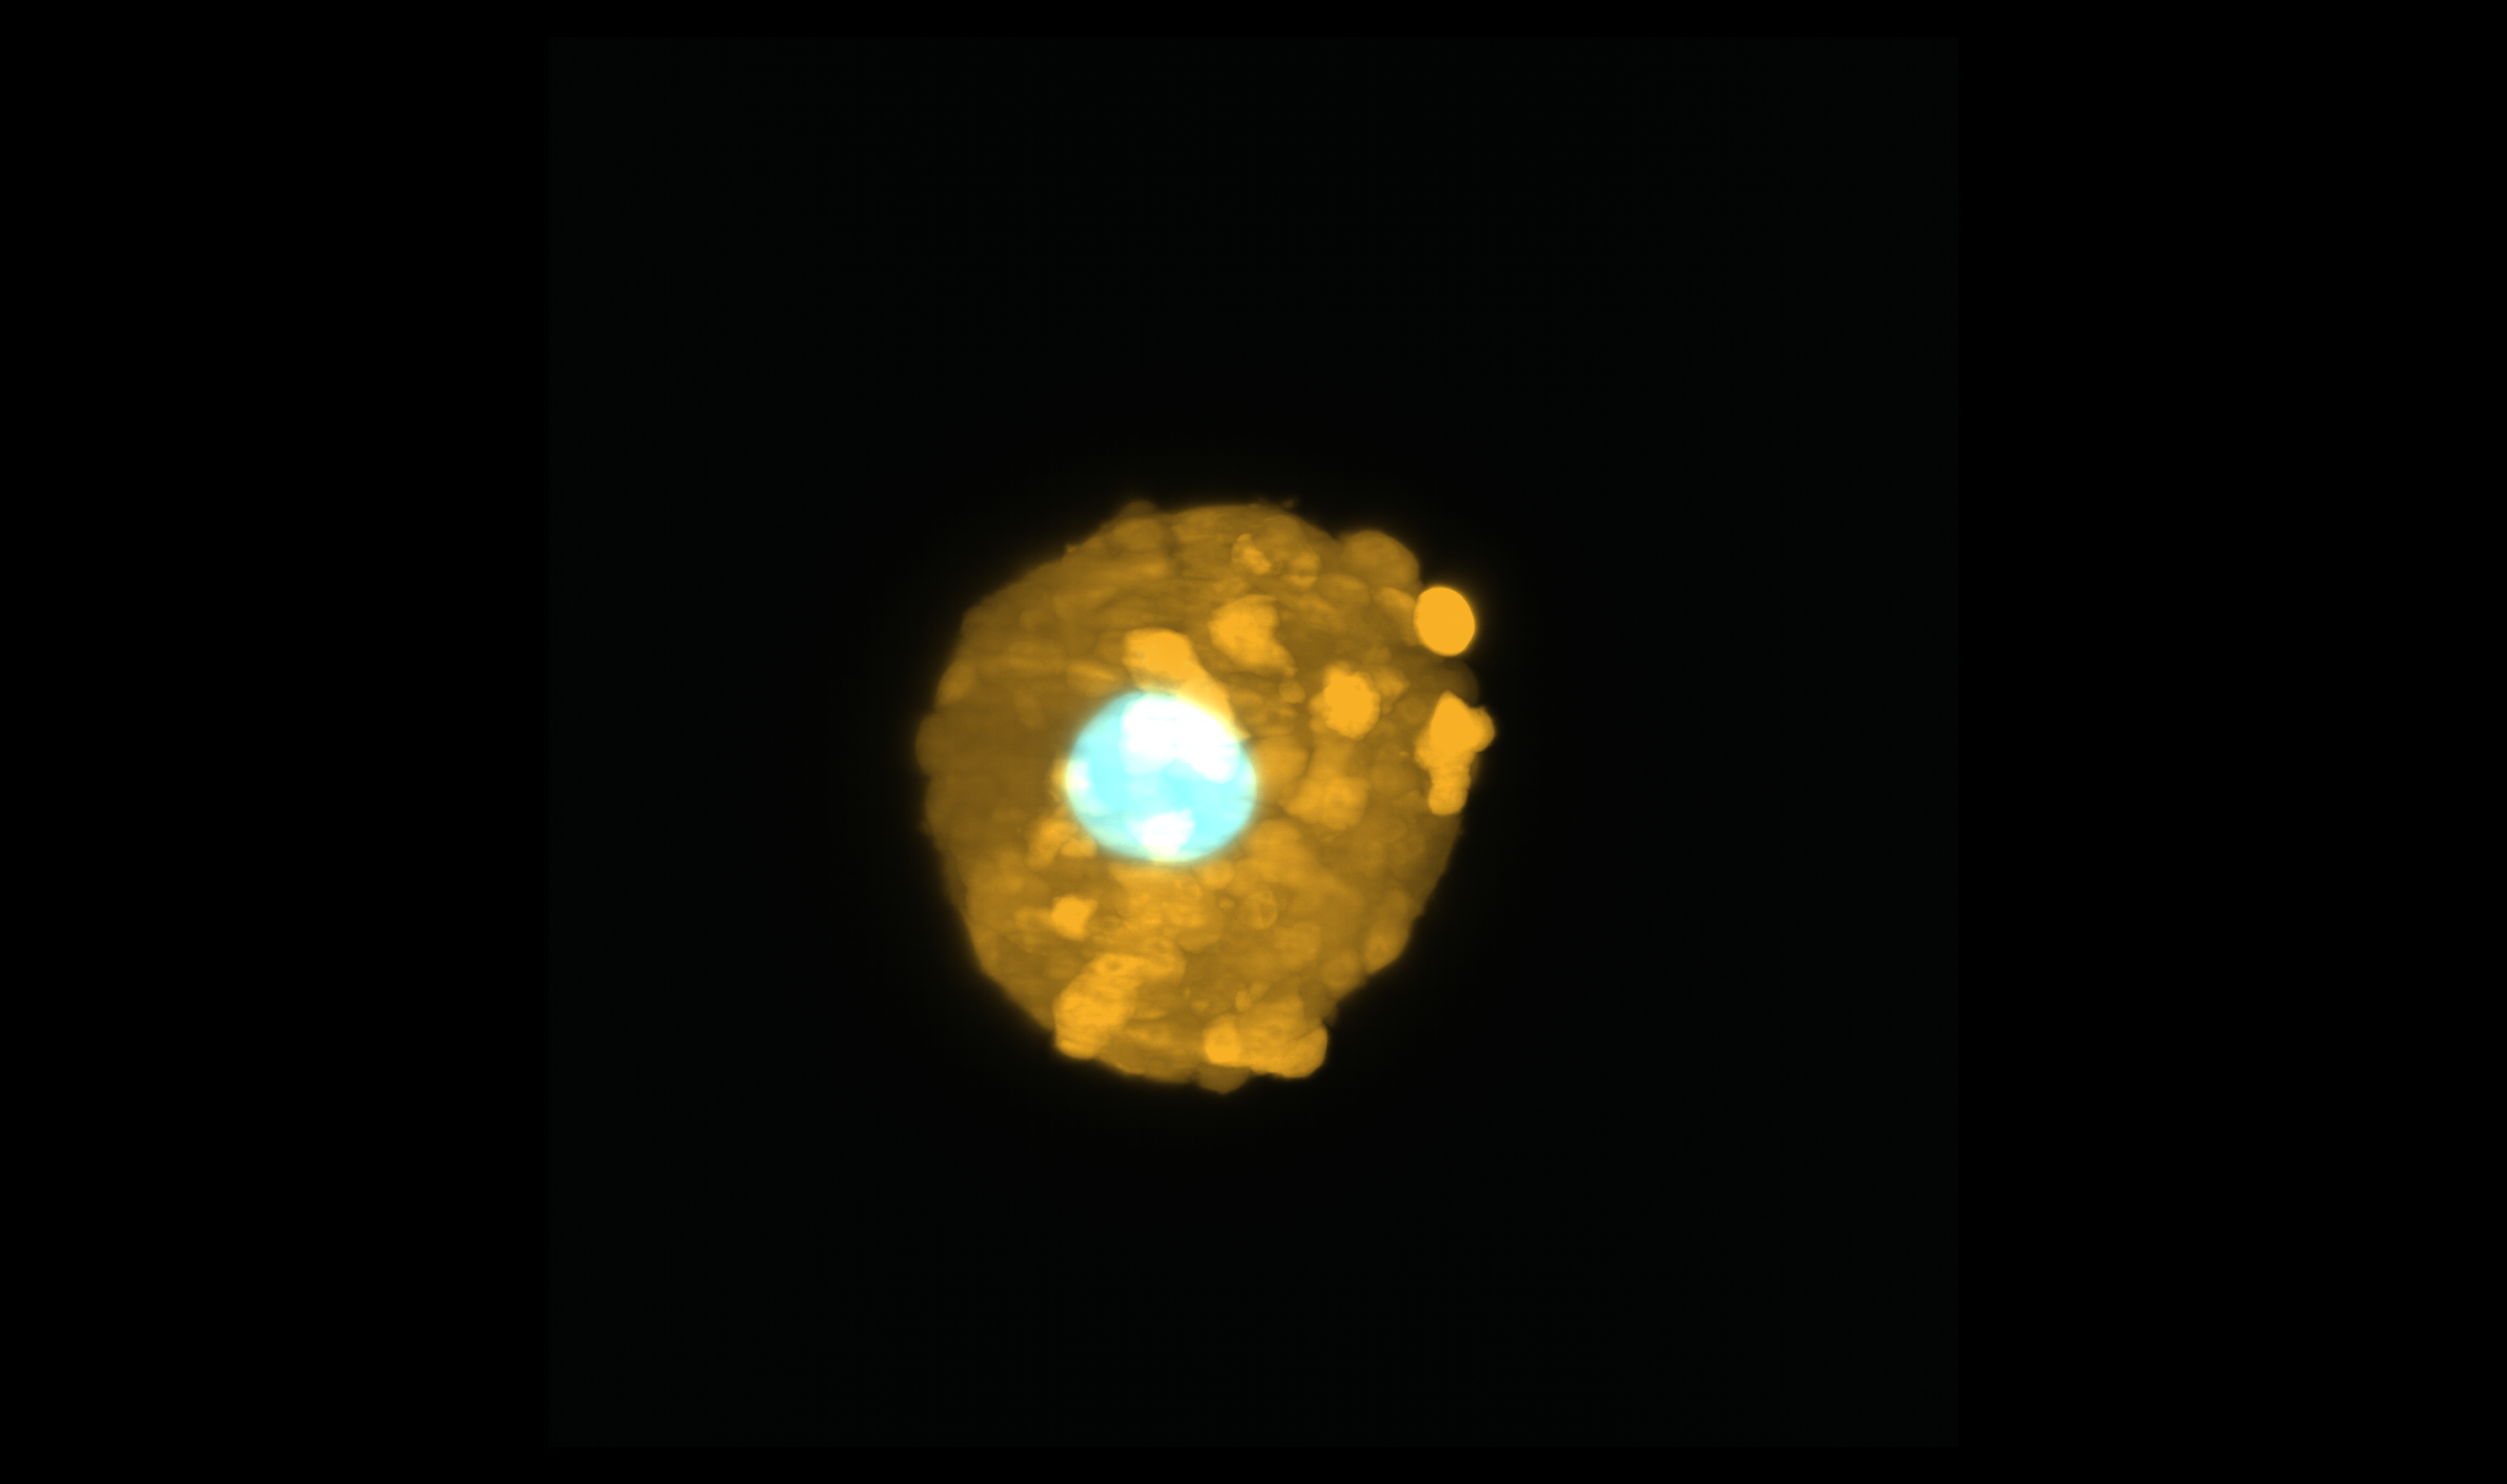

In [6]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image.dask_data[0, 0], name = 'Spheroid', colormap='bop orange',
                 scale=list(image.physical_pixel_sizes), blending='additive',
                contrast_limits=[154.0, 4410.0])
viewer.add_image(image.dask_data[0, 1], name = 'Dropplet', colormap='bop blue',
                 scale=list(image.physical_pixel_sizes), blending='additive',
                 contrast_limits=[169.0, 2842.0])

napari.utils.nbscreenshot(viewer, canvas_only=True)

## Droplet analysis

before we look at the spheroid, let's have a look at the droplet. Due to the large array size, reshaping the data is not an option, so we'll have to go straight to points and surfaces from here.

### Preprocessing

Preprocessing follows a slightly different scheme here. The steps include:

- Thresholding (simple threshold otsu)
- Surface reconstruction (marching cubes)
- Surface decimation (We don't need all the >100k vertices of the surface do achieve a good representation)

In [7]:
droplet_binary = nsbatwm.threshold_otsu(image.dask_data[0, 1])
viewer.add_labels(droplet_binary, name = 'Droplet binary', scale = list(image.physical_pixel_sizes))

<Labels layer 'Droplet binary' at 0x1888021cd60>

In [8]:
# Create surface
surface = list(nppas.label_to_surface(droplet_binary))
surface[0] = surface[0] * np.array(image.physical_pixel_sizes)[None, :]  # apply scale to point coordinates
viewer.add_surface(surface, name='Dropplet')

<Surface layer 'Dropplet [1]' at 0x1888b7d2610>

In [9]:
# Adjust vertex density
mesh = vedo.mesh.Mesh((surface[0], surface[1]))
vertices = nppas.sample_points_uniformly(surface, number_of_points=int(mesh.area() * surface_density))
len(vertices)
viewer.add_points(vertices, size=1.0, face_color='orange')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<Points layer 'vertices' at 0x1888bb5f250>

### Surface refinement

With the decimated surface, we can now appl the developed surface tracing method in `napari-stress`. Caveat: Is this legitimate to do for non-isotropic image data??

In [10]:
surf = napari_stress.reconstruct_surface(vertices)
result = napari_stress.trace_refinement_of_surface(image.data[0, 1], surf,
                                                  trace_length=10.0, sampling_distance=0.1,
                                                  scale=np.array(image.physical_pixel_sizes),
                                                  show_progress=True,
                                                  selected_fit_type='quick',
                                                  remove_outliers=True,
                                                  interquartile_factor=3.0)

TypeError: range() takes no keyword arguments